In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from dateutil.parser import parse as date_parse
%matplotlib inline
pd.options.mode.chained_assignment = None

In [48]:
who_data = pd.read_csv('https://covid.ourworldindata.org/data/full_data.csv')
jhu_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/'+
                       'COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+
                       'time_series_19-covid-Confirmed.csv')
covidtracking_data = pd.read_csv('http://covidtracking.com/api/states/daily.csv')

In [3]:
jhu_data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,75,82,114,147,177,212,272,322,411,599
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,701,773,839,825,878,889,924,963,1007,1086
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,200,212,226,243,266,313,345,385,432,455
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,2
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,197,238,428,566,673,790,900,1030,1183,1306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,NaN,Dominica,15.4150,-61.3710,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
483,NaN,Grenada,12.1165,-61.6790,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
484,NaN,Mozambique,-18.6657,35.5296,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
485,NaN,Syria,34.8021,38.9968,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
covidtracking_data_ = covidtracking_data.copy()
covidtracking_data_['dateChecked'] = covidtracking_data_['dateChecked'].map(lambda x: date_parse(x))
covidtracking_data_['date'] = covidtracking_data_['date'].map(lambda x: date_parse(str(x)))
covidtracking_reduced = covidtracking_data_.groupby(['state', 'date']).sum().reset_index()

In [5]:
country_filter = ['China', 'South Korea', 'Italy', 'France', 'Spain', 'United States']

In [6]:
country_mapper = {
        'Korea, South': 'South Korea',
        'US': 'United States'    
}
jhu_data['Country/Region'] = jhu_data['Country/Region'].map(country_mapper).fillna(jhu_data['Country/Region'])

In [7]:
assert set(country_filter) - set(jhu_data['Country/Region']) == set()

In [8]:
jhu_data_reduced = jhu_data.drop(columns=['Lat', 'Long', 'Province/State'])
jhu_data_reduced = jhu_data_reduced.groupby('Country/Region').max()
jhu_data_reduced = jhu_data_reduced.stack().reset_index()
jhu_data_reduced.columns = ['location', 'date', 'total_cases']
jhu_data_reduced['date'] = pd.to_datetime(jhu_data_reduced['date'])

In [9]:
state_abbr = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
state_lookup = state_abbr.set_index('Abbreviation', drop=True).squeeze().to_dict()

In [10]:
def get_state(place):
    p = place.split(',')
    if len(p) > 1:
        return state_lookup[p[1].replace('.', '').strip()]
    return place
def drop_cities(place):
    if place.find(',') > 0:
        return None
    else:
        return place

In [11]:
jhu_data_us = jhu_data[jhu_data['Country/Region'] == 'United States']
jhu_data_us['Province/State'] = jhu_data_us['Province/State'].map(drop_cities).dropna()
jhu_data_us_reduced = jhu_data_us.drop(columns=['Lat', 'Long', 'Country/Region'])
# jhu_data_us_reduced = jhu_data_us_reduced.drop(0, axis='rows')
jhu_data_us_reduced = jhu_data_us_reduced.groupby('Province/State').max()
jhu_data_us_reduced = jhu_data_us_reduced.stack().reset_index()
jhu_data_us_reduced.columns = ['state', 'date', 'total_cases']
jhu_data_us_reduced['date'] = pd.to_datetime(jhu_data_us_reduced['date'])

In [12]:
t0_threshold = 100
who_data_t0 = who_data.query('total_cases >= @t0_threshold')
jhu_data_t0 = jhu_data_reduced.query('total_cases >= @t0_threshold')
jhu_data_us_t0 = jhu_data_us_reduced.query('total_cases >= 1')

In [13]:
t0_date_w = who_data_t0.groupby('location').min()['date']
t0_date_j = jhu_data_t0.groupby('location').min()['date']
t0_date_j_us = jhu_data_us_t0.groupby('state').min()['date']

In [14]:
who_data_t0.loc[:, 't0_date'] = who_data_t0['location'].map(t0_date_w)
jhu_data_t0.loc[:, 't0_date'] = jhu_data_t0['location'].map(t0_date_j)
jhu_data_us_t0.loc[:, 't0_date'] = jhu_data_us_t0['state'].map(t0_date_j_us)

In [15]:
who_data_t0.loc[:, 'since_t0'] = pd.to_datetime(who_data_t0['date']) - pd.to_datetime(who_data_t0['t0_date'])
who_data_t0.loc[:, 'since_t0']  = who_data_t0['since_t0'].map(lambda x: x.days)
jhu_data_t0.loc[:, 'since_t0'] = pd.to_datetime(jhu_data_t0['date']) - pd.to_datetime(jhu_data_t0['t0_date'])
jhu_data_t0.loc[:, 'since_t0']  = jhu_data_t0['since_t0'].map(lambda x: x.days)
jhu_data_t0.loc[:, 'since_t0'] = jhu_data_t0.loc[:, 'since_t0'].where(jhu_data_t0['since_t0'] > 0, 0)
jhu_data_us_t0.loc[:, 'since_t0'] = pd.to_datetime(jhu_data_us_t0['date']) - pd.to_datetime(jhu_data_us_t0['t0_date'])
jhu_data_us_t0.loc[:, 'since_t0']  = jhu_data_us_t0['since_t0'].map(lambda x: x.days)
jhu_data_us_t0.loc[:, 'since_t0'] = jhu_data_us_t0.loc[:, 'since_t0'].where(jhu_data_us_t0['since_t0'] > 0, 0)

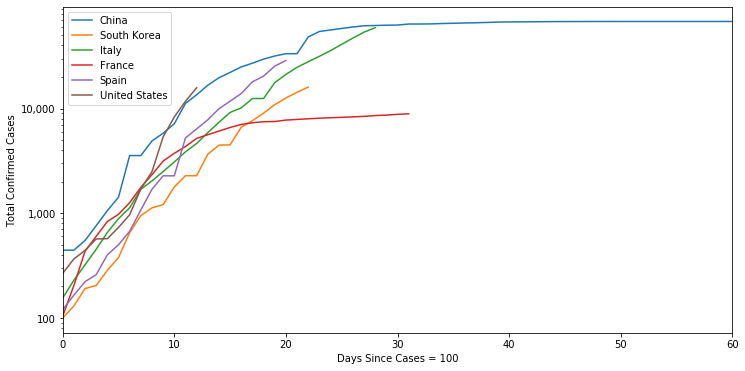

In [16]:
ax = plt.gca()
p=jhu_data_t0[jhu_data_t0['location'].isin(country_filter)].groupby('location').plot(x='since_t0', 
                                                                                     y='total_cases', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(country_filter)
ax.set_xlabel('Days Since Cases = 100')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

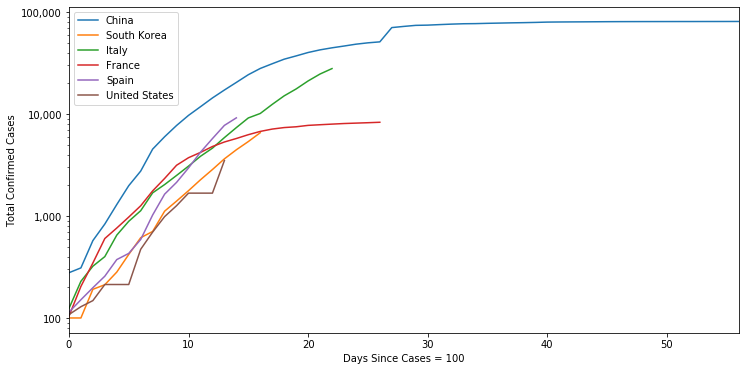

In [17]:
ax = plt.gca()
p=who_data_t0[who_data_t0['location'].isin(country_filter)].groupby('location').plot(x='since_t0', y='total_cases', ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(country_filter)
ax.set_xlabel('Days Since Cases = 100')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [18]:
state_filter = ['Georgia', 'New York', 'California', 'Ohio', 'Washington']

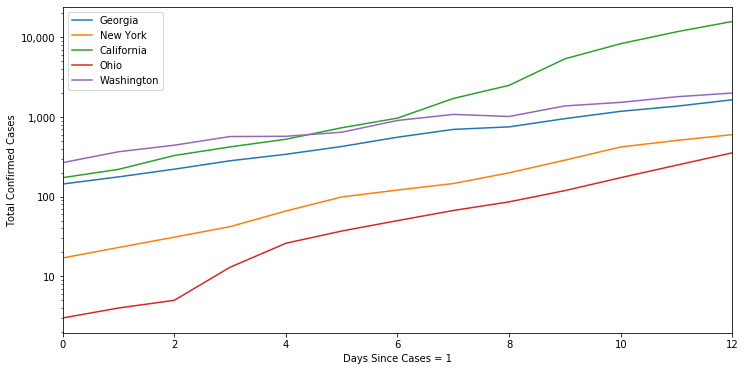

In [19]:
ax = plt.gca()
p=jhu_data_us_t0[jhu_data_us_t0['state'].isin(state_filter)].groupby('state').plot(x='since_t0', 
                                                                                     y='total_cases', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(state_filter)
ax.set_xlabel('Days Since Cases = 1')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

jhu_data_us_t0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f8e7450>,
      dtype=object)

In [97]:
top25_states = covidtracking_reduced.groupby('state').max()['total'].sort_values(ascending=False)[:25].keys()

In [96]:
covidtracking_reduced_top25

Index(['NY', 'WA', 'CA', 'FL', 'TX', 'IL', 'WI', 'NC', 'MA', 'PA', 'NM', 'MN',
       'CO', 'GA', 'TN', 'UT', 'LA', 'VA', 'MI', 'CT', 'OR', 'NV', 'ME', 'NJ',
       'NH'],
      dtype='object', name='state')

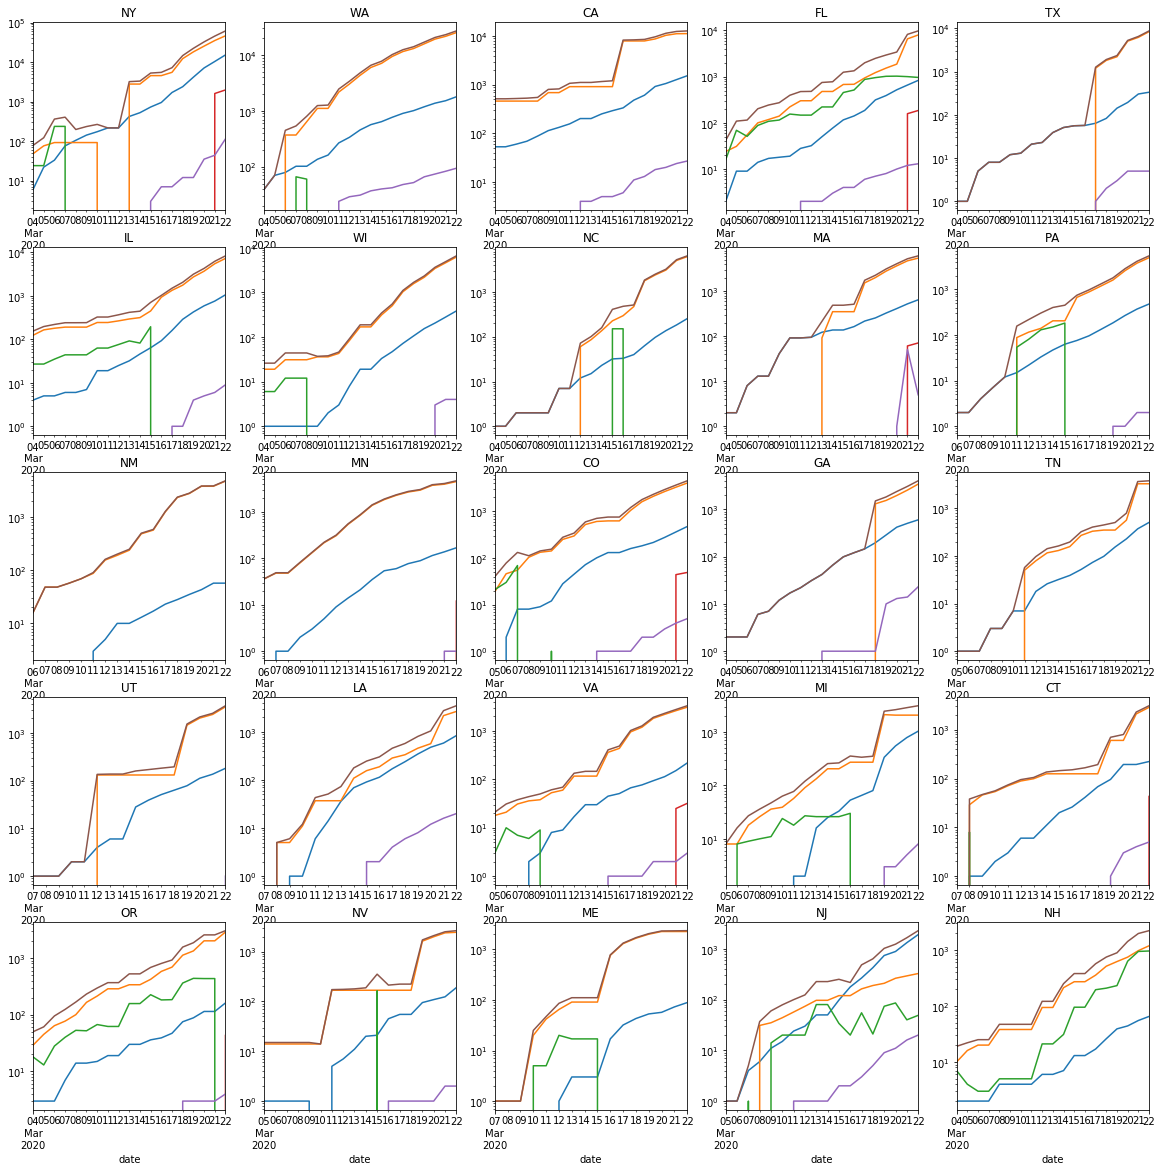

In [99]:
fig = plt.figure(figsize=(20,20))
ax_list = fig.subplots(5, 5).flatten()
for ix, state in enumerate(top25_states):
    if ix > 24:
        continue
    plot_data = covidtracking_reduced.query('state == @state').drop(columns='state').set_index('date')
    plot_data.plot(ax=ax_list[ix],legend=False, title=state, logy=True)

In [53]:
import matplotlib.pyplot as plt